In [258]:
import numpy as np
from spine_detector.utils import load_mri
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

import matplotlib.animation as animation
%matplotlib inline

In [337]:
def get_gradient2d(data):
    gradient = [np.diff(data, 1, axis=0),
                np.diff(data, 1, axis=1)]
    norm_x = np.zeros_like(data)
    norm_y = np.zeros_like(data)
    
    norm_x[:-1] += gradient[0]
    norm_x[1:] += gradient[0]

    norm_y[:, :-1] += gradient[1]
    norm_y[:, 1:] += gradient[1]
    
    norm = np.sqrt(np.power(norm_x, 2) + np.power(norm_y, 2))
    
    assert not np.argwhere(np.isnan(norm))
    assert np.all(norm >= 0)
    return norm

def box_filtering2d(data, degree=2, size=(3,3)):
    csum = np.cumsum(get_gradient2d(data) ** degree, axis=0)
    csum = np.cumsum(csum, axis=1)

    csum = (csum[2 * size[0]:] - csum[:-2 * size[0]])/(2*size[0] + 1)
    
    csum = (csum[:, 2 * size[1]:] - csum[:, :-2 * size[1]])/(2*size[1] + 1)
    
    csum = np.power(csum, 1/degree)
    
    result = np.zeros_like(data)
    result[size[0]: -size[0], size[1]: -size[1]] = csum 
    
    #result = np.nan_to_num(result)
    assert not np.argwhere(np.isnan(result))
    

    return result

In [338]:
def box_filtering2d_with_gauss(data, degree=2, size=(3,3), sigma=2):
    filtered = gaussian_filter(get_gradient2d(data) ** degree, sigma)
    
    csum = np.cumsum(filtered, axis=0)
    csum = np.cumsum(csum, axis=1)

    csum = (csum[2 * size[0]:] - csum[:-2 * size[0]])/(2*size[0] + 1)
    
    csum = (csum[:, 2 * size[1]:] - csum[:, :-2 * size[1]])/(2*size[1] + 1)
    
    csum = np.power(csum, 1/degree)
    
    result = np.zeros_like(data)
    result[size[0]: -size[0], size[1]: -size[1]] = csum 
    
    #result = np.nan_to_num(result)
    assert not np.argwhere(np.isnan(result))
    

    return result

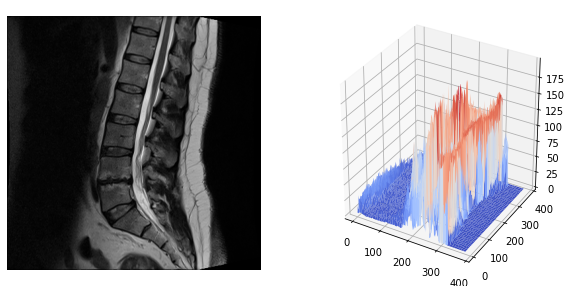

In [354]:
from spine_detector.utils import load_mri
fig = plt.figure(figsize=(10,5))
dcms = load_mri('..\\test-data\\0001\T2_TSE_SAG_384_0002')

tst_image = dcms[7].pixel_array


ax = fig.add_subplot(1, 2, 1)
ax.imshow(tst_image, cmap='gray')
ax.axis('off')
normalized_image = tst_image / 4  

x = np.arange(0, 384)
y = np.arange(0, 384)
x,y = np.meshgrid(x,y)

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot_surface(x, y, normalized_image, cmap=cm.coolwarm)
# color map 2d

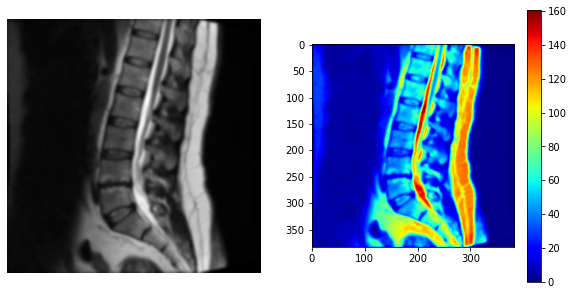

In [355]:
filtered_image = gaussian_filter(normalized_image, 2)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(filtered_image, cmap='gray')
ax.axis('off') 

ax = fig.add_subplot(1,2,2)
imax = ax.imshow(filtered_image, cmap='jet')

#imax = ax[2][1].imshow(box_filtered, cmap='jet', clim=(0, 2.))
fig.colorbar(imax, ax=ax)
# colormap 2d

Пофильтруем   
Варьируемые параметры:
* d 
* радиусы градиентного фильтра  

Учитывая эксперименты на одномерном случае, также применим и гауссов фильтр

Как будем смотреть:
Послайсно вертикальный, горизонтальный, саму маску и возможно сам срез.
Для просмотра среза - нам нужно как-то применяеть маску
Вариант:
* умножение
* коэффициент отсечения
* что-то еще

d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


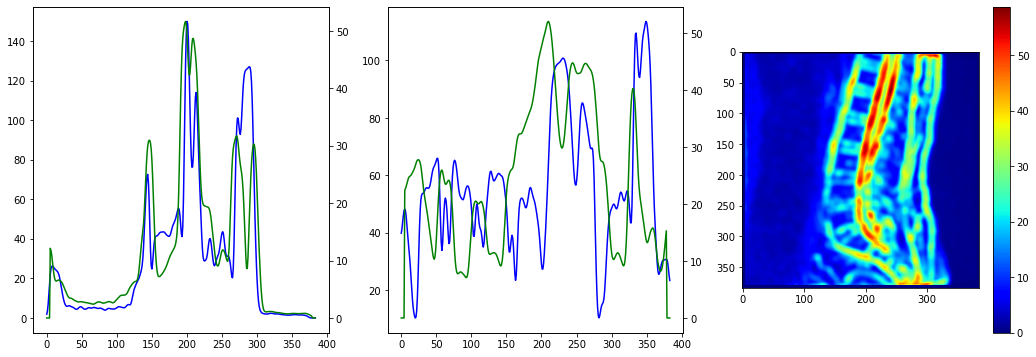

In [356]:
%matplotlib inline
h_slice_number = 170
v_slice_number = 190
degree = 1.8

box_filtered = box_filtering2d_with_gauss(normalized_image, degree=degree, size=(5,5), sigma=2)
fig, ax = plt.subplots(ncols=3, figsize=(18,6))


ax[0].plot(filtered_image[h_slice_number], '-b')
ax2 = ax[0].twinx()
h_slice = box_filtered[h_slice_number]
ax2.plot(h_slice, '-g')

ax[1].plot(filtered_image[:, v_slice_number], '-b')
ax12 = ax[1].twinx()
ax12.plot(box_filtered[:, v_slice_number], '-g')

imax = ax[2].imshow(box_filtered, cmap='jet')
fig.colorbar(imax, ax=ax[2])

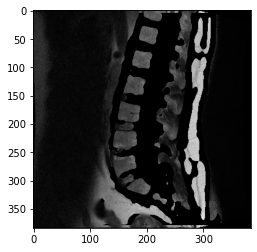

In [344]:
mask = box_filtered < 4

plt.imshow(tst_image * mask, cmap='gray')

In [353]:
normalized_image.max()

20.345744680851066

Проблема:

При больших ящиках происходит смещение влево. Вызвано это тем, что мы считаем магнитуду градиента от левого верхнего угла.

Нужно ли с этим бороться?
Если да, то как?

d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app


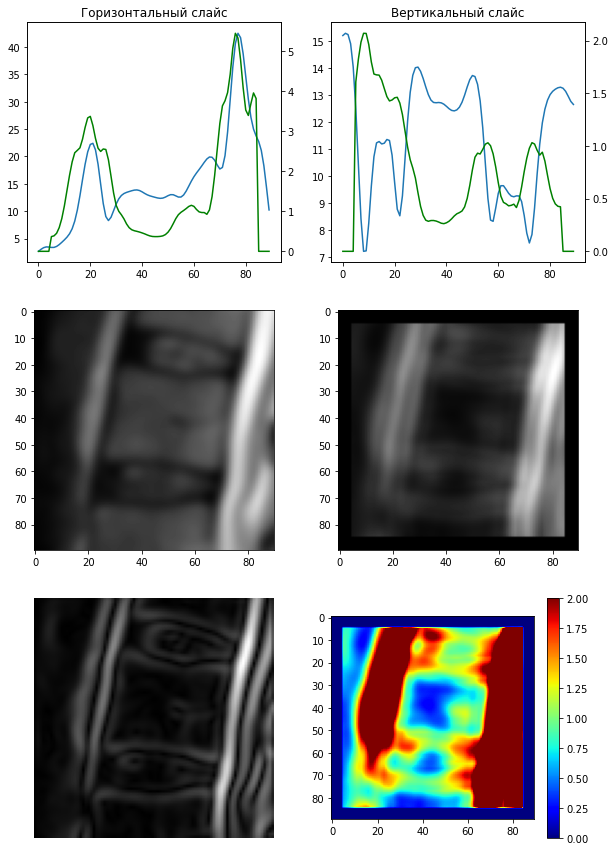

In [329]:
%matplotlib inline

only_one_vert = filtered_image[140:230, 120:210]

box_filtered = box_filtering2d(only_one_vert, 0.7, (5,5))
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))

ax[0][0].plot(only_one_vert[45])
ax[0][0].set_title('Горизонтальный слайс')
ax00 = ax[0][0].twinx()
ax00.plot(box_filtered[45], '-g')

ax[0][1].plot(only_one_vert[:, 45])
ax[0][1].set_title('Вертикальный слайс')
ax01 = ax[0][1].twinx()
ax01.plot(box_filtered[:, 45], '-g')

ax[1][0].imshow(only_one_vert, cmap='gray')

ax[1][1].imshow(box_filtered, cmap='gray')

ax[2][0].imshow(get_gradient2d(only_one_vert), cmap='gray')
ax[2][0].axis('off')

imax = ax[2][1].imshow(box_filtered, cmap='jet', clim=(0, 2.))
fig.colorbar(imax, ax=ax[2][1])


Проблема:
Приращения по x на порядки больше нежели чем по y.

Понятно почему - потому что изменения градиента по вертикали много больше чем горизонатли 

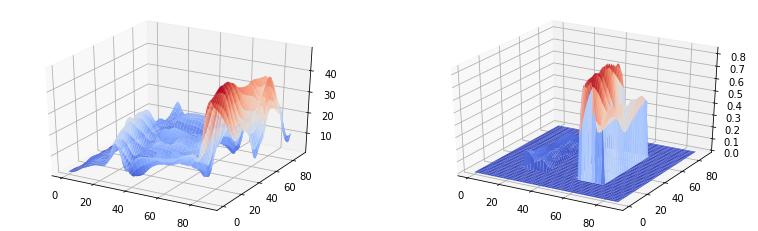

In [267]:
fig = plt.figure(figsize=plt.figaspect(0.3))
x = np.arange(0, 90)
y = np.arange(0, 90)
x,y = np.meshgrid(x,y)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(x, y, only_one_vert, cmap=cm.coolwarm)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(x,y, box_filtered, cmap=cm.coolwarm)

d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in power


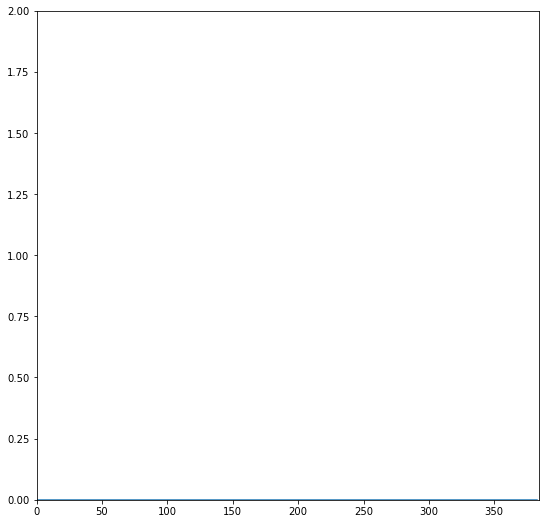

In [274]:
plt.rcParams['animation.ffmpeg_path'] = 'D:\\apps\\ffmpeg\\bin\\ffmpeg.exe' 


h_slice_number = 170
v_slice_number = 190

degrees = np.hstack([np.arange(0.2, 1.8, 0.1), np.arange(1.8, 0.2, -0.1)])

fig, ax = plt.subplots(figsize=(9,9))
ax.axis([0, 384, 0, 2])
l, = ax.plot([],[])

def animate(i):
    box_filtered = box_filtering2d(filtered_image, degrees[i], size=(25, 25))
    h_slice = box_filtered[h_slice_number]
    l.set_data(np.arange(0,384), h_slice)


ani = animation.FuncAnimation(fig, animate, frames=len(degrees))

from IPython.display import HTML
HTML(ani.to_html5_video())

Графики для изменения степени получили - поиграемся с размерами области

d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in power
d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


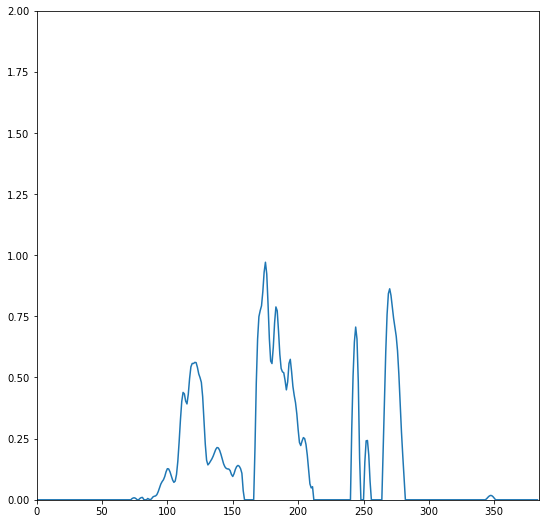

In [279]:
sizes = np.hstack([np.arange(25,0,-1), np.arange(1, 25)])
fig, ax = plt.subplots(figsize=(9,9))
ax.axis([0, 384, 0, 2])
l, = ax.plot([],[])

def animate(i):
    box_filtered = box_filtering2d(filtered_image, 1.8, size=(sizes[i], sizes[i]))
    h_slice = box_filtered[h_slice_number]
    l.set_data(np.arange(0, 384), h_slice)


ani = animation.FuncAnimation(fig, animate, frames=len(sizes))

from IPython.display import HTML
HTML(ani.to_html5_video())

d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app


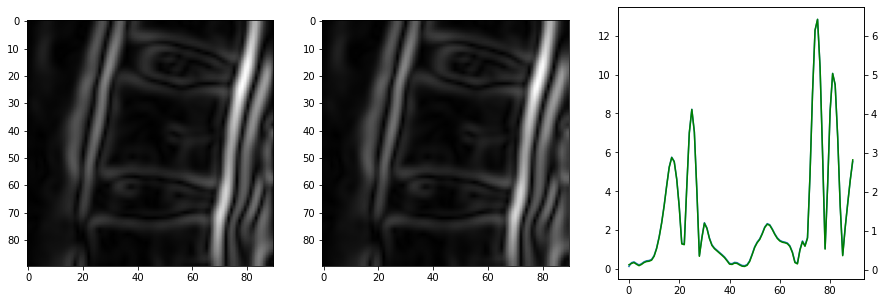

In [255]:
%matplotlib inline
gaussed = gaussian_filter(only_one_vert, 2)

grad = get_gradient2d(gaussed)

gradv2 = np.gradient(gaussed)
magn_grad = np.zeros((90, 100))
magn_grad = np.sqrt(np.power(gradv2[0],2) + np.power(gradv2[1],2))

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(grad, cmap='gray')
ax[1].imshow(magn_grad, cmap='gray')

ax3t = ax[2].twinx()

ax[2].plot(grad[40])
ax3t.plot(magn_grad[40], '-g')

In [295]:
size = (3,4)
a = np.ones((3,3))
b = np.pad(a, ((size[0],size[0]),(size[1],size[1])), 'constant')
b

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])